In [1]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import clip
import os
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns


In [2]:
# Caltech101 Dataset Preprocessing

transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Resize(256),
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    ]) # mean = 0.5, std = 0.5

# set batch_size
batch_size = 1

# set number of workers
num_workers = 1

# load train data
trainset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Removing the irrelevant class
classes = [d.name for d in os.scandir(os.path.join('./data', 'caltech101', '101_ObjectCategories')) if d.is_dir()]
classes.remove('BACKGROUND_Google')
classes.sort()         

In [4]:
t2im = transforms.ToPILImage()
im2t = transforms.PILToTensor()
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [5]:
# Compute embeddings for each sample
embeddings = []
truths = []
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if inputs.shape == torch.Size([1, 3, 224, 224]):
            image_features = model.encode_image(inputs)
            embeddings.append(image_features.reshape(-1,1).squeeze().detach().cpu().numpy())
            truths.append(classes[labels])
print(len(embeddings), embeddings[0].shape, len(truths))

/Users/ashwin/miniconda3/envs/fl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


8296 (512,) 8296


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.asarray(embeddings), truths, test_size=0.2, random_state=18)

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model on the training data
lda.fit(X_train, y_train)

# Transform the data using the LDA model
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [7]:
# Train a classifier on the transformed data (you can use any classifier of your choice)
# Here, we'll use a simple logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_lda)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8186746987951807


/Users/ashwin/miniconda3/envs/fl/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


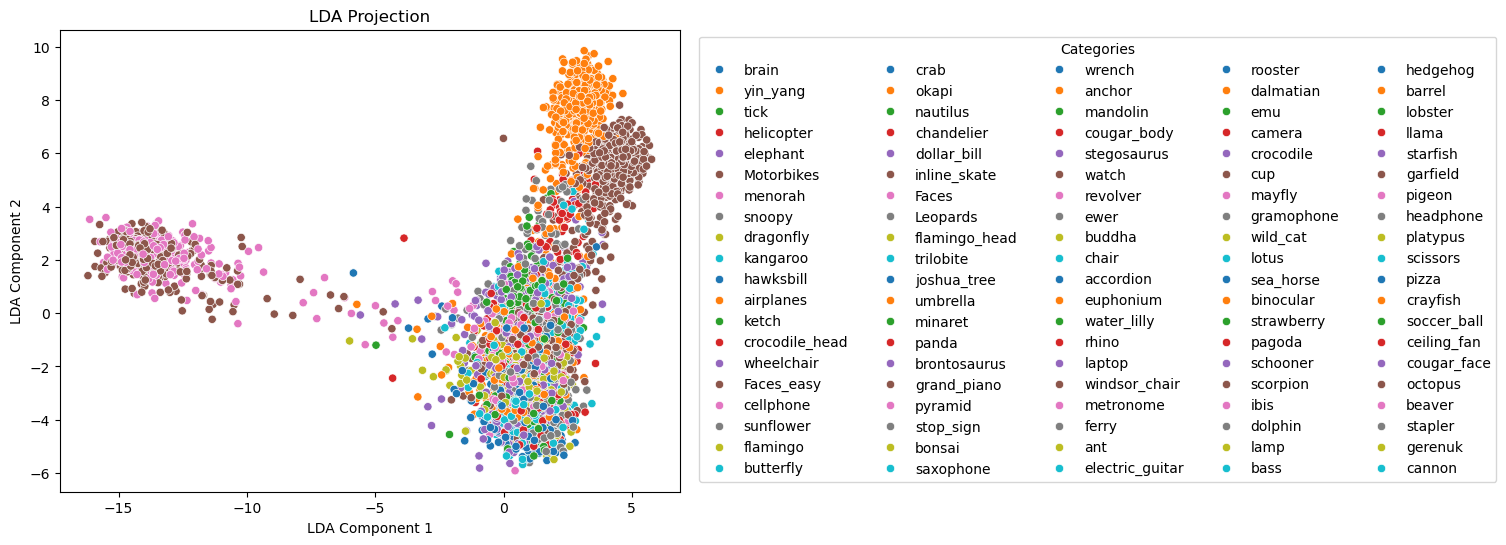

In [28]:
# Assuming X_lda is the transformed data and y is the class labels
plt.figure(figsize=(8, 6))
plot = sns.scatterplot(x=X_train_lda[:, 0], y=X_train_lda[:, 1], hue=y_train, palette='tab10', legend=True)
plot.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=5, title='Categories')
plt.title('LDA Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

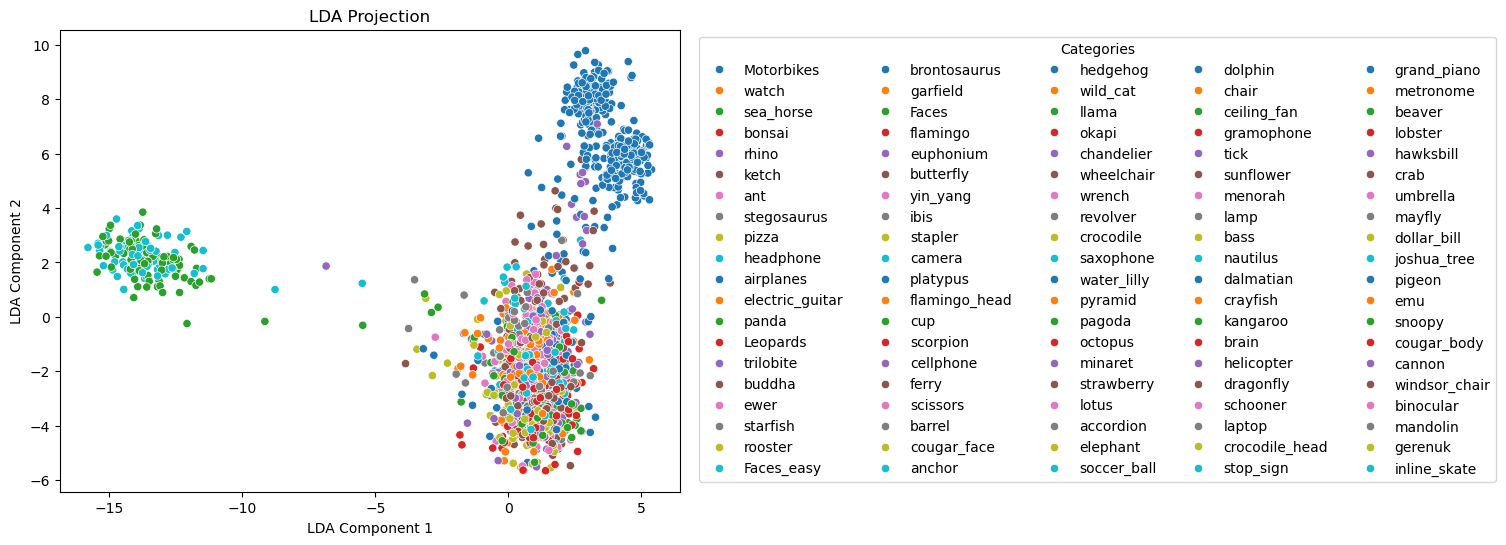

In [32]:
# Assuming X_lda is the transformed data and y is the class labels
plt.figure(figsize=(8, 6))
plot = sns.scatterplot(x=X_test_lda[:, 0], y=X_test_lda[:, 1], hue=y_test, palette='tab10', legend=True)
plot.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=5, title='Categories')
plt.title('LDA Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

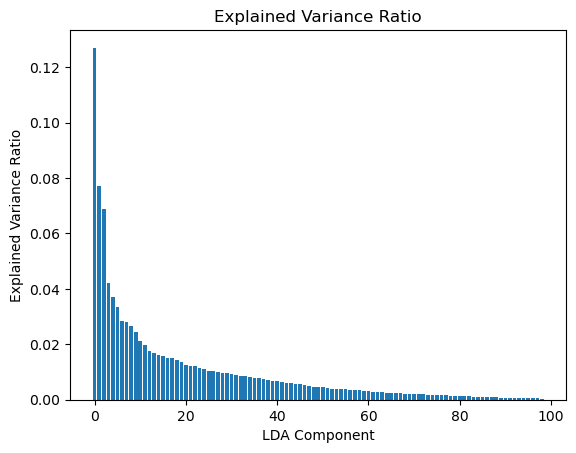

In [11]:
plt.bar(range(len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.xlabel('LDA Component')
plt.ylabel('Explained Variance Ratio')
plt.show()